<a href="https://colab.research.google.com/github/MarcoCerino23/Awesome/blob/main/baseline_49_submitted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1rPuqfmPD7NsZJ8nrbnOTfNWKJtu59ajC/Homework 2


## ⚙️ Import Libraries

In [ ]:
# Set seed for reproducibility

seed = 42



# Import necessary libraries

import os
from datetime import datetime

if 'KAGGLE_URL_BASE' in os.environ:
    IN_KAGGLE = True
else:
    IN_KAGGLE = False


# Set environment variables before importing modules

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

os.environ['PYTHONHASHSEED'] = str(seed)

os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'



# Suppress warnings

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

warnings.simplefilter(action='ignore', category=Warning)



# Import necessary modules

import logging

import random

import numpy as np



# Set seeds for random number generators in NumPy and Python

np.random.seed(seed)

random.seed(seed)



# Import TensorFlow and Keras

import tensorflow as tf

from tensorflow import keras as tfk

from tensorflow.keras import layers as tfkl



# Set seed for TensorFlow

tf.random.set_seed(seed)

tf.compat.v1.set_random_seed(seed)



# Reduce TensorFlow verbosity

tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)



# Print TensorFlow version

print(tf.__version__)



# Import other libraries

import os

import math

from PIL import Image

from keras import backend as K

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd


# Configure plot display settings

sns.set(font_scale=1.4)

sns.set_style('white')

plt.rc('font', size=14)

%matplotlib inline

2.17.1


## ⏳ Load the Data

In [ ]:
data = np.load("data/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
# Set batch size for training

BATCH_SIZE = 64



# Set learning rate for the optimiser

LEARNING_RATE = 1e-3



# Set early stopping patience threshold

PATIENCE = 20



# Set maximum number of training epochs

EPOCHS = 1#1000



# Set data split size for training and validation

SPLITS_SIZE = 200

## 🛠️ Train and Save the Model

In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
y_train = y_train[..., np.newaxis]
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
# Split the paths (not the data) into training, validation, and test sets

print("Splitting data...")



train_img, val_img, train_lbl, val_lbl = train_test_split(

    X_train, y_train, test_size=SPLITS_SIZE, random_state=seed

)

print("Data splitted!")



print(f"\nNumber of images:")

print(f"Train: {len(train_img)}")

print(f"Validation: {len(val_img)}")

print(f"Test: {len(X_test)}")

Splitting data...
Data splitted!

Number of images:
Train: 2415
Validation: 200
Test: 10022


In [ ]:
# Definizione della category mapping

category_map = {

    0: 0,  # Background -> Background

    1: 1,  # Soil -> Soil

    2: 2,  # Bedrock -> Bedrock

    3: 3,  # Sand -> Sand

    4: 4,  # Big Rock -> Big Rock

}

NUM_CLASSES = 5  # Da 0 a 4

print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 5


In [ ]:
def load_single_image(image, label, input_size=(64, 128)):

    """

    Preprocessa un'immagine e la sua label.

    """

    # Resize e normalizza l'immagine

    image = tf.image.resize(image, input_size)

    #image = tf.cast(image, tf.float32) / 255.0  # Normalizza su [0, 1]



    # Resize la label

    label = tf.image.resize(label, input_size, method='nearest')  # Metodo adatto per label discrete

    label = tf.cast(label, tf.int32)  # Assicurati che le label siano interi



    return image, label


In [ ]:
def apply_category_mapping(label):

    """

    Apply category mapping to labels.

    """

    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)

    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)

    table = tf.lookup.StaticHashTable(

        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),

        default_value=0

    )

    return table.lookup(label)

In [ ]:

@tf.function

def random_flip(image, label, seed=None):

    #Consistent random horizontal flip.

    if seed is None:

        seed = np.random.randint(0, 1000000)

    flip_prob = tf.random.uniform([], seed=seed)

    image = tf.cond(

        flip_prob > 0.5,

        lambda: tf.image.flip_left_right(image),

        lambda: image

    )

    label = tf.cond(

        flip_prob > 0.5,

        lambda: tf.image.flip_left_right(label),

        lambda: label

    )

    return image, label


In [ ]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):

    """

    Create a memory-efficient TensorFlow dataset.

    """

    # Create dataset from file paths

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))



    if shuffle:

        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)



    # Load images and labels

    dataset = dataset.map(

        load_single_image,

        num_parallel_calls=tf.data.AUTOTUNE

    )



    # Apply category mapping

    dataset = dataset.map(

        lambda x, y: (x, apply_category_mapping(y)),

        num_parallel_calls=tf.data.AUTOTUNE

    )



    if augment:

        dataset = dataset.map(

            lambda x, y: random_flip(x, y, seed=seed),

            num_parallel_calls=tf.data.AUTOTUNE

        )



    # Batch the data

    dataset = dataset.batch(batch_size, drop_remainder=False)

    dataset = dataset.prefetch(tf.data.AUTOTUNE)



    return dataset

In [ ]:
# Create the datasets

print("Creating datasets...")

train_dataset = make_dataset(

    train_img, train_lbl,

    batch_size=BATCH_SIZE,

    shuffle=True,

    augment=False,

    seed=seed

)



val_dataset = make_dataset(

    val_img, val_lbl,

    batch_size=BATCH_SIZE,

    shuffle=False

)

"""

test_dataset = make_dataset(

    test_img, test_lbl,

    batch_size=BATCH_SIZE,

    shuffle=False

)

"""

print("Datasets created!")



# Check the shape of the data

for images, labels in train_dataset.take(1):

    input_shape = images.shape[1:]

    print(f"\nInput shape: {input_shape}")

    print("Images shape:", images.shape)

    print("Labels shape:", labels.shape)

    print("Labels dtype:", labels.dtype)

    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


(2615, 64, 128, 1)
Visualizing examples from the training set:


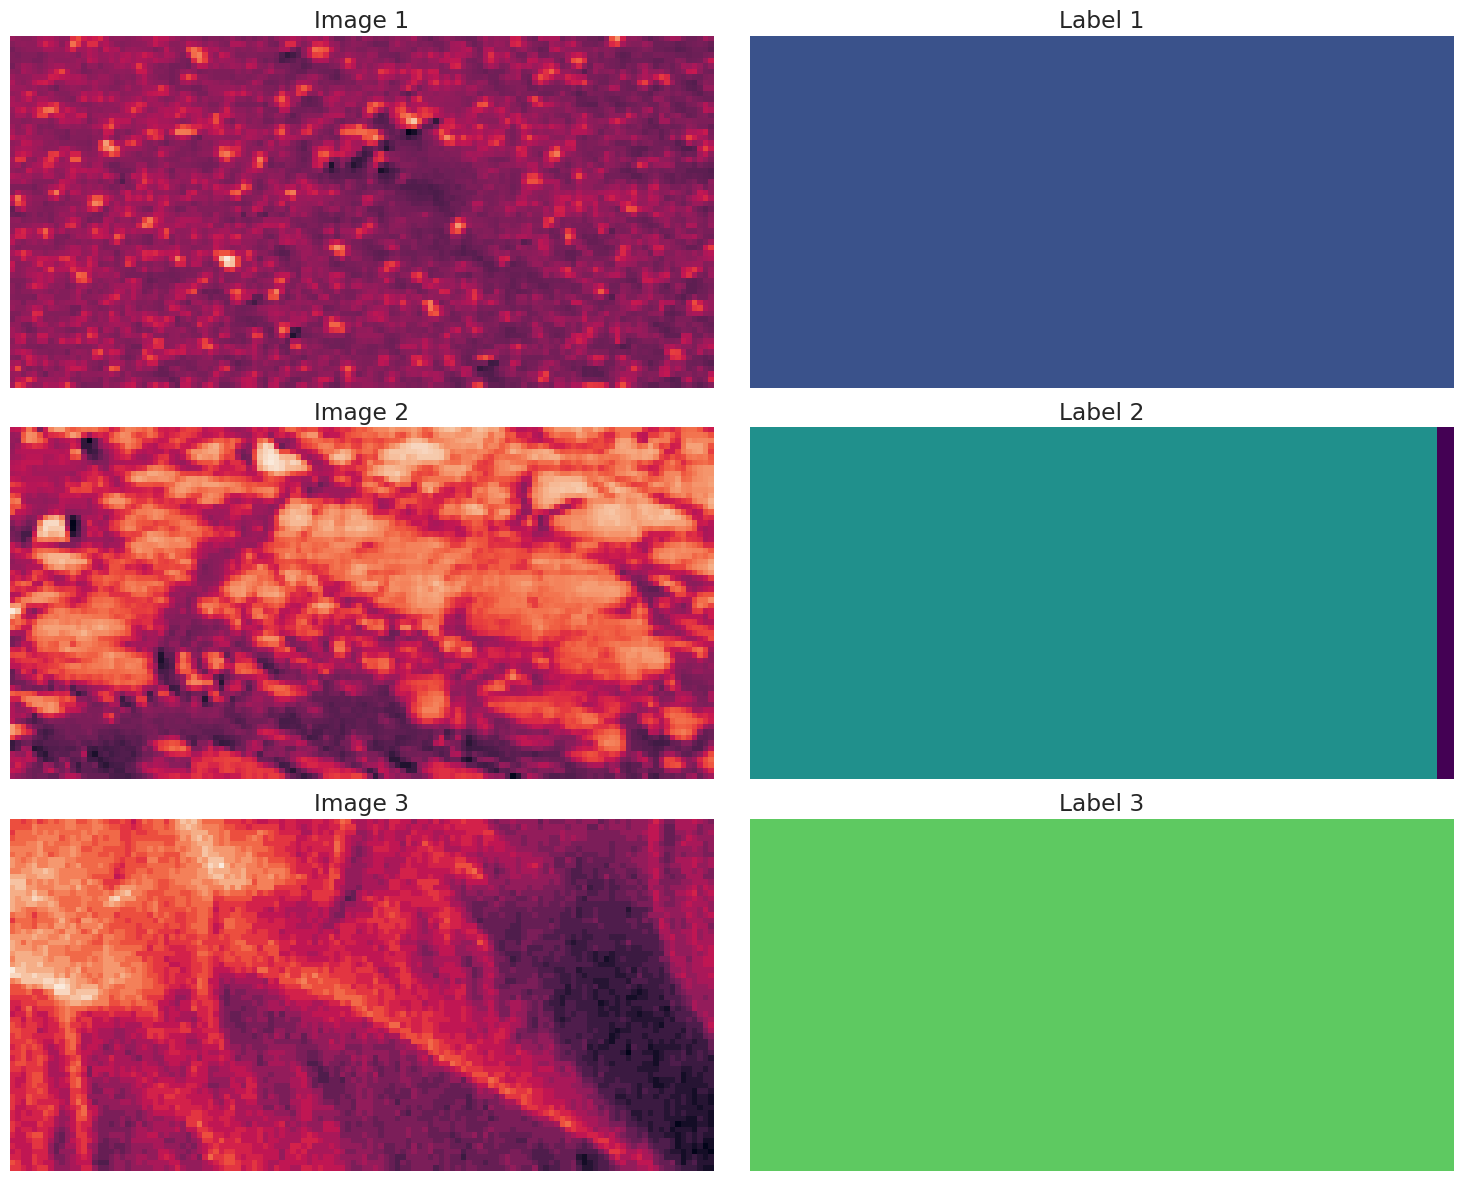

In [ ]:

def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)
        print(colormap)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j])
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

print(X_train.shape)
# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=3)

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):

    # Initialise the input tensor

    x = input_tensor



    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks

    for i in range(stack):

        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)

        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)

        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)



    # Return the transformed tensor

    return x

In [ ]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    """
    Modello U-Net esteso con più livelli.
    """
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')  # Livello 1
    d1 = tfkl.MaxPooling2D()(down_block_1)
    d1 = tfkl.Dropout(0.25)(d1)  # Dropout aggiunto

    down_block_2 = unet_block(d1, 64, name='down_block2_')           # Livello 2
    d2 = tfkl.MaxPooling2D()(down_block_2)
    d2 = tfkl.Dropout(0.5)(d2)  # Dropout aggiunto

    down_block_3 = unet_block(d2, 128, name='down_block3_')          # Livello 3 (aggiunto)
    d3 = tfkl.MaxPooling2D()(down_block_3)
    d3 = tfkl.Dropout(0.5)(d3)  # Dropout aggiunto

    down_block_4 = unet_block(d3, 256, name='down_block4_')          # Livello 4 (aggiunto)
    d4 = tfkl.MaxPooling2D()(down_block_4)
    d4 = tfkl.Dropout(0.5)(d4)  # Dropout aggiunto

    # Bottleneck
    bottleneck = unet_block(d4, 512, name='bottleneck')              # Bottleneck più grande

    # Upsampling path
    u1 = tfkl.Conv2DTranspose(256, kernel_size=2, strides=2, padding='same', name='up_block1_transpose')(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_4])
    u1 = tfkl.Dropout(0.5)(u1)
    u1 = unet_block(u1, 256, name='up_block1_')

    u2 = tfkl.Conv2DTranspose(128, kernel_size=2, strides=2, padding='same', name='up_block2_transpose')(u1)
    u2 = tfkl.Concatenate()([u2, down_block_3])
    u2 = tfkl.Dropout(0.5)(u2)
    u2 = unet_block(u2, 128, name='up_block2_')

    u3 = tfkl.Conv2DTranspose(64, kernel_size=2, strides=2, padding='same', name='up_block3_transpose')(u2)
    u3 = tfkl.Concatenate()([u3, down_block_2])
    u3 = tfkl.Dropout(0.5)(u3)
    u3 = unet_block(u3, 64, name='up_block3_')

    u4 = tfkl.Conv2DTranspose(32, kernel_size=2, strides=2, padding='same', name='up_block4_transpose')(u3)
    u4 = tfkl.Concatenate()([u4, down_block_1])
    u4 = tfkl.Dropout(0.5)(u4)
    u4 = unet_block(u4, 32, name='up_block4_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u4)

    # Definisci il modello
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet_extended')
    return model

Model: "UNet_extended"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dropout (Dropout)      │ (None, 32, 64, 32)   │            0 │ max_pooling2d[0][0] │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ dropout[0][0]       │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2      

 Total params: 7,771,429 (29.65 MB)

 Trainable params: 7,765,541 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

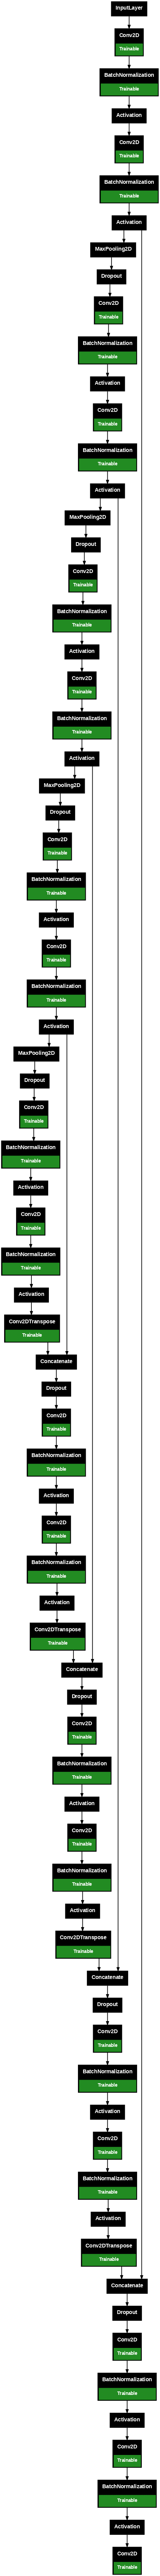

In [ ]:
model = get_unet_model()



# Print a detailed summary of the model with expanded nested layers and trainable parameters.

model.summary(expand_nested=True, show_trainable=True)



# Generate and display a graphical representation of the model architecture.

tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [ ]:
# Define custom Mean Intersection Over Union metric
from keras.saving import register_keras_serializable


class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):

    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):

        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

        if labels_to_exclude is None:

            labels_to_exclude = [0]  # Default to excluding label 0

        self.labels_to_exclude = labels_to_exclude



    def update_state(self, y_true, y_pred, sample_weight=None):

        # Convert predictions to class labels

        y_pred = tf.math.argmax(y_pred, axis=-1)



        # Flatten the tensors

        y_true = tf.reshape(y_true, [-1])

        y_pred = tf.reshape(y_pred, [-1])



        # Apply mask to exclude specified labels

        for label in self.labels_to_exclude:

            mask = tf.not_equal(y_true, label)

            y_true = tf.boolean_mask(y_true, mask)

            y_pred = tf.boolean_mask(y_pred, mask)



        # Update the state

        return super().update_state(y_true, y_pred, sample_weight)



# Visualization callback

class VizCallback(tf.keras.callbacks.Callback):

    def __init__(self, image_path, label_path, frequency=5):

        super().__init__()

        self.image_path = image_path

        self.label_path = label_path

        self.frequency = frequency



    def on_epoch_end(self, epoch, logs=None):

        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs

            image, label = load_single_image(self.image_path, self.label_path)

            label = apply_category_mapping(label)

            image = tf.expand_dims(image, 0)

            pred = self.model.predict(image, verbose=0)

            y_pred = tf.math.argmax(pred, axis=-1)

            y_pred = y_pred.numpy()



            # Create colormap

            num_classes = NUM_CLASSES

            colormap = create_segmentation_colormap(num_classes)



            plt.figure(figsize=(16, 4))



            # Input image

            plt.subplot(1, 3, 1)

            plt.imshow(image[0])

            plt.title("Input Image")

            plt.axis('off')



            # Ground truth

            plt.subplot(1, 3, 2)

            colored_label = apply_colormap(label.numpy(), colormap)

            plt.imshow(colored_label)

            plt.title("Ground Truth Mask")

            plt.axis('off')



            # Prediction

            plt.subplot(1, 3, 3)

            colored_pred = apply_colormap(y_pred[0], colormap)

            plt.imshow(colored_pred)

            plt.title("Predicted Mask")

            plt.axis('off')



            plt.tight_layout()

            plt.show()

            plt.close()

In [ ]:
# Compile the model



print("Compiling model...")

model.compile(

    loss= tf.keras.losses.SparseCategoricalCrossentropy(),#tf.keras.losses.SparseCategoricalCrossentropy()

    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE,weight_decay=1e-4),

    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]

)

print("Model compiled!")

Compiling model...
Model compiled!


In [ ]:
# Setup callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(

    monitor='val_mean_iou',

    mode='max',

    patience=PATIENCE,

    restore_best_weights=True

)



viz_callback = VizCallback(val_img[0], val_lbl[0])






reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_iou',  # Puoi cambiare con 'val_mean_io_u' se usi IoU
    mode="max",
    factor=0.1,          # Riduci il learning rate di 0.2, prima era di 0.5
    patience=10,          # Aspetta 5 epoche senza miglioramenti
    min_delta=0.001,
    min_lr=1e-5,         # Non scendere sotto 1e-6
    verbose=1            # Mostra messaggi quando il learning rate cambia

)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3120 - loss: 1.6412 - mean_iou: 0.0976   

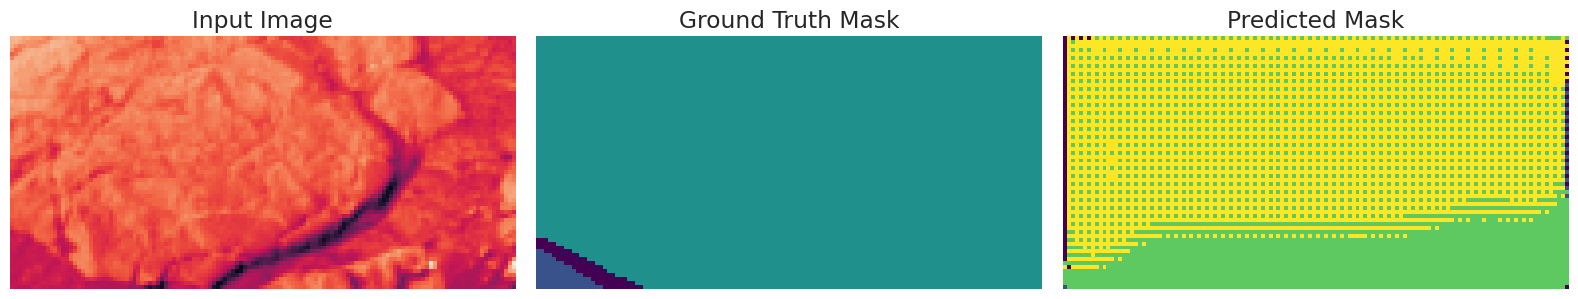

38/38 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.3134 - loss: 1.6370 - mean_iou: 0.0986 - val_accuracy: 0.0784 - val_loss: 14.4758 - val_mean_iou: 0.0366 - learning_rate: 0.0010
Final validation Mean Intersection Over Union: 3.66%
Model saved to model_241201_130225.keras


In [ ]:



# Train the model

history = model.fit(

    train_dataset,

    epochs=EPOCHS,

    validation_data=val_dataset,

    callbacks=[early_stopping, viz_callback,reduce_lr],#reduce_lr

    verbose=1

).history



# Calculate and print the final validation accuracy

final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)

print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')



timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:

#model_filename = "Unet_48.92.keras"
model = tfk.models.load_model(model_filename,compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from Unet_48.92.keras


In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```